In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
import numpy as np
import os
import re
import h5py
import pandas as pd
import scipy.io as sio
from PIL import Image

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def get_penultimate_activation(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for layer in self.classifier[:-1]:
            x = layer(x)
        return x

    
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import sys
print("Using device:", device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
print('Cuda available:', torch.cuda.is_available())
sys.stdout.flush()

Using device: cuda:0
NVIDIA GeForce GTX 1080 Ti
Cuda available: True


In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = '/datasets/imagenet-ilsvrc2012/training/'
imagenet_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

train_loader = DataLoader(imagenet_dataset, batch_size=64, shuffle=True)

alex = AlexNet(num_classes=1000).to(device)
print("Model is on device:", next(alex.parameters()).device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex.parameters(), lr=0.001)

Model is on device: cuda:0


In [5]:
first_image, first_label = imagenet_dataset[0]
print(first_image, first_label)

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


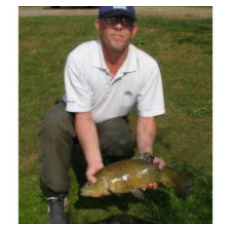

In [5]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = first_image.permute(1, 2, 0).numpy() * std + mean

plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
def find_latest_checkpoint(path='.'):
    checkpoints = [f for f in os.listdir(path) if f.startswith('checkpoint_epoch_') and f.endswith('.pth.tar')]
    if not checkpoints:
        return None
    latest_checkpoint = max(checkpoints, key=lambda f: int(f.split('_')[2].split('.')[0]))
    return latest_checkpoint

# Load the latest checkpoint if available
latest_checkpoint = find_latest_checkpoint()
if latest_checkpoint:
    checkpoint = torch.load(latest_checkpoint)
    alex.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    running_loss = checkpoint['loss'] * len(train_loader)

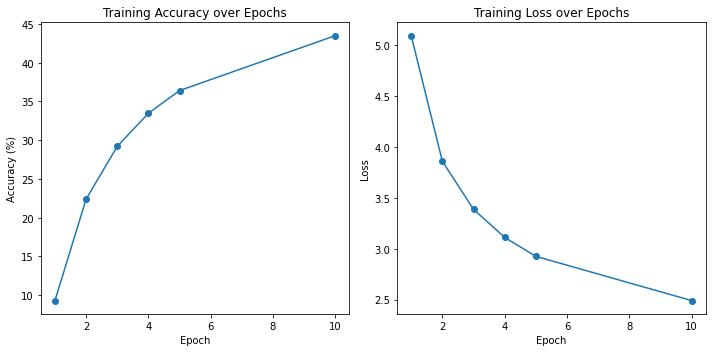

In [7]:
import os
import torch
import matplotlib.pyplot as plt

def plot_metrics(path):
    checkpoints = [f for f in os.listdir(path) if f.startswith('checkpoint_epoch_') and f.endswith('.pth.tar')]
    if not checkpoints:
        print("No checkpoints found.")
        return
    
    epochs = []
    losses = []
    accuracies = []

    for checkpoint in sorted(checkpoints, key=lambda x: int(x.split('_')[2].split('.')[0])):
        checkpoint_path = os.path.join(path, checkpoint)
        data = torch.load(checkpoint_path)
        epochs.append(data['epoch'])
        losses.append(data['loss'])
        accuracies.append(data['accuracy'])

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracies, marker='o')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_metrics('.')

In [20]:
import numpy as np

def load_data(region='ventral_visual_data', shared='515'):
    temp = []
    for i in range(1, 9):
        temp.append(np.load(f'/uss/KhoslaLab/NSD_Preprocessed/ventral_visual_data/subj{i}_coco_IDs.npy'))

    if shared == '515':
        shared_ids = temp[0].copy()
        for i in range(1, 8):
            shared_ids = np.intersect1d(shared_ids, temp[i].copy())
    elif shared == '1000':
        shared_ids = temp[0].copy()
        for i in [1, 4, 6]:
            shared_ids = np.intersect1d(shared_ids, temp[i].copy())

    all_indexes = []
    for i in range(1, 9):
        indexes = np.load(f'/uss/KhoslaLab/NSD_Preprocessed/ventral_visual_data/subj{i}_coco_IDs.npy')
        temp = [int(np.where(indexes == j)[0]) for j in shared_ids]
        all_indexes.append(np.array(temp))

    Y = []
    for i in range(1, 9):
        Y_temp = np.load(f'/uss/KhoslaLab/NSD_Preprocessed/ventral_visual_data/subj{i}.npy')[all_indexes[i-1]]
        Y_temp = np.asarray(Y_temp)
        Y_temp = Y_temp[:, Y_temp.sum(0) != 0]
        Y_temp[np.isnan(Y_temp)] = 0
        Y_temp[np.isinf(Y_temp)] = 0        
        Y.append(Y_temp)

    return shared_ids, Y

# Example usage
region = 'ventral_visual_data'
shared = '515'
shared_ids, Y = load_data(region, shared)
for i in Y: 
    print(i.shape)

(515, 7601)
(515, 8182)
(515, 8160)
(515, 7639)
(515, 6615)
(515, 9661)
(515, 6512)
(515, 8343)


In [9]:
def get_activations(model, input_image):
    activations = {}
    def hook_fn(module, input, output):
        activations[module] = output.detach()
    hooks = []
    for layer in model.features:
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ReLU) or isinstance(layer, nn.MaxPool2d):
            hooks.append(layer.register_forward_hook(hook_fn))
    for layer in model.classifier:
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.ReLU) or isinstance(layer, nn.Dropout):
            hooks.append(layer.register_forward_hook(hook_fn))
    model(input_image)
    
    for hook in hooks:
        hook.remove()
    
    return activations

def get_activations(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu().numpy()
    return hook

def load_image(image_id, transform):
    image_path = f'/uss/KhoslaLab/NSD_Preprocessed/images/{image_id}.jpg'
    image = Image.open(image_path).convert('RGB')
    return transform(image)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=1000).to(device)
checkpoint = torch.load('checkpoint_epoch_5.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the layers to capture
layers_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10', 'avgpool', 'classifier.1', 'classifier.4', 'classifier.6']

activations = {}
for name, module in model.named_modules():
    if name in layers_list:
        module.register_forward_hook(get_activations(name))

# Process images and get activations
activation_dict = {layer: [] for layer in layers_list}
for image_id in shared_ids:
    input_image = load_image(image_id, transform).unsqueeze(0).to(device)
    model(input_image)
    for name in layers_list:
        activation_dict[name].append(activations[name])

# Example to print the shape of activations from each layer
for layer in layers_list:
    X = np.array(activation_dict[layer]).reshape(len(shared_ids), -1)
    X -= X.sum(axis=0) / X.shape[0]
    X[np.isnan(X)] = 0
    X[np.isinf(X)] = 0
    activation_dict[layer] = X
    print(f'Layer {layer} activations shape: {X.shape}')


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer features.0 activations shape: (515, 193600)
Layer features.3 activations shape: (515, 139968)
Layer features.6 activations shape: (515, 64896)
Layer features.8 activations shape: (515, 43264)
Layer features.10 activations shape: (515, 43264)
Layer avgpool activations shape: (515, 9216)
Layer classifier.1 activations shape: (515, 4096)
Layer classifier.4 activations shape: (515, 4096)
Layer classifier.6 activations shape: (515, 1000)


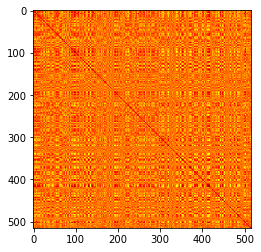

In [10]:
temp = 1 - np.corrcoef(activation_dict['classifier.6'])
plt.imshow(temp, cmap = 'hot')

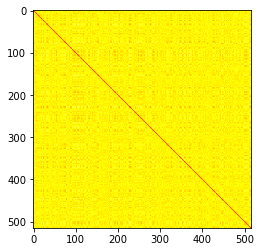

In [14]:
temp2 = 1 - np.corrcoef(Y[0])
plt.imshow(temp2, cmap = 'hot')

In [ ]:
temp = np.array(temp[np.triu_indices(temp.shape[0], k=1)])
temp2 = np.array(temp2[np.triu_indices(temp2.shape[0], k = 1)])

In [16]:
from scipy.stats import kendalltau
def RSA(X, Y):
    temp = 1 - np.corrcoef(Y)
    temp2 = 1 - np.corrcoef(X)
    temp = np.array(temp[np.triu_indices(temp.shape[0], k=1)])
    temp2 = np.array(temp2[np.triu_indices(temp2.shape[0], k=1)])
    return kendalltau(temp, temp2)[0]

In [17]:
kendalltau(temp, temp2)

KendalltauResult(correlation=0.24676596635842926, pvalue=0.0)

In [18]:
RSA(activation_dict['features.10'],Y[0])

0.12328552268202475

In [ ]:
Y.shape

In [34]:
shared_ids, _ = load_data()

# Example fMRI data (ensure Y is properly formatted)
n_epochs = 10  # Total number of epochs
skip_epochs = [6, 7, 8, 9]  # Epochs to skip
epochs_rsa_scores = []

for epoch in range(1, n_epochs + 1):
    if epoch in skip_epochs:
        continue  # Skip the specified epochs
    
    checkpoint_path = f'checkpoint_epoch_{epoch}.pth.tar'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    penultimate_activations = []
    for image_id in shared_ids:
        input_image = load_image(image_id, transform).unsqueeze(0).to(device)
        activation = model.get_penultimate_activation(input_image)
        penultimate_activations.append(activation.cpu().detach().numpy().reshape(-1))

    penultimate_activations = np.vstack(penultimate_activations)
    X = penultimate_activations
    Y_rsa = Y 

    if len(X.shape) != 2 or len(Y_rsa.shape) != 2 or X.shape[0] != Y_rsa.shape[0]:
        print(f'Invalid shapes for RSA computation: X shape {X.shape}, Y shape {Y_rsa.shape}')
        continue

    rsa_score = RSA(X, Y_rsa)
    epochs_rsa_scores.append(rsa_score)
    print(f'Epoch {epoch}: RSA score = {rsa_score}')


Epoch 1: RSA score = 0.2129481346865741
Epoch 2: RSA score = 0.20888027187397223
Epoch 3: RSA score = 0.2132295476661938
Epoch 4: RSA score = 0.20547228421504393
Epoch 5: RSA score = 0.20031659702313195
Epoch 10: RSA score = 0.18529691049574054


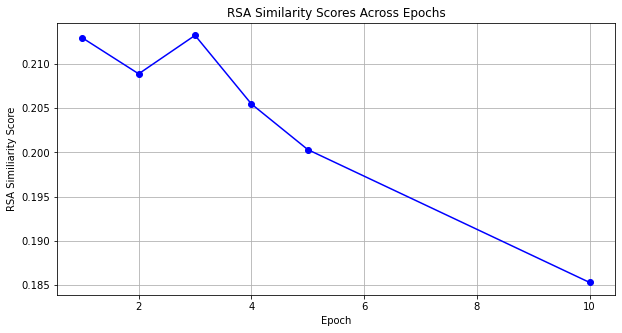

In [31]:
plt.figure(figsize=(10, 5))
plt.plot([epoch for epoch in range(1, n_epochs + 1) if epoch not in skip_epochs], epochs_rsa_scores, marker='o', linestyle='-', color='b')
plt.title('RSA Similarity Scores Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('RSA Similiarity Score')
plt.grid(True)
plt.show()

In [40]:
Y.shape

(515, 7601)

In [ ]:
def pairwise_correlation(A, B):
    am = A - np.mean(A, axis = 0, keepdims = True)
    bm = B - np.mean(B, axis = 0, keepdims = True)
    return am.T @ bm / (np.sqrt(
        np.sum(am**2, axis = 0,
              keepdims = True)).T * np.sqrt(
        np.sum(bm**2, axis = 0, keepdims = True)))

In [ ]:
def normalize(X):
    mean = np.nanmean(X, 0)
    stddev = np.nanstd(X, 0)
    X_zm = X - mean
    X_zm_unit = X_zm / stddev
    X_zm_unit[np.isnan(X_zm_unit)] = 0
    return X_zm_unit

In [4]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
def LinearPredictivity(X, Y):
    all_corrs = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(X):
        predictor = RidgeCV(alphas=np.logspace(-8, 2, 17))
        predictor.fit(normalize(X[train_idx]), Y[train_idx])
        
        y_pred = predictor.predict(normalize(X[test_idx]))
        
        try:
            model_corrs = pairwise_correlation(y_pred, Y[test_idx])
            corr = np.nanmean(np.diag(model_corrs))
            all_corrs.append(corr)
        except Exception as e:
            print(f"Error: {e}")
            model_corrs = [pairwise_correlation(y_pred[:, i], Y[test_idx][:, i])[0] for i in range(y_pred.shape[1])]
            all_corrs.append(np.mean(model_corrs))
            
    return np.mean(all_corrs)

In [29]:
a = LinearPredictivity(activation_dict['classifier.6'], Y[0])

In [30]:
a

0.14832166527659257